In [1]:
##############################################
# 1. LIBRARIES & SEED
##############################################
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, LSTM, GRU
from sklearn.model_selection import train_test_split

# Reproducibility
np.random.seed(1234)
PYTHONHASHSEED = 0


2025-07-07 12:49:35.382000: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751892575.583232      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751892575.643209      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
##############################################
# 2. DATA LOADING (VERİ SETLERİNİN YÜKLENMESİ)
##############################################
import pandas as pd

# 2.1. TRAIN DATA
train_path = '/kaggle/input/pred-maintanance-data/PM_train.txt'
train_df = pd.read_csv(train_path, sep=" ", header=None)
train_df.dropna(axis=1, inplace=True)

# 2.2. TEST DATA
test_path = '/kaggle/input/pred-maintanance-data/PM_test.txt'
test_df = pd.read_csv(test_path, sep=" ", header=None)
test_df.dropna(axis=1, inplace=True)

# 2.3. GROUND TRUTH
truth_path = '/kaggle/input/pred-maintanance-data/PM_truth.txt'
truth_df = pd.read_csv(truth_path, sep=" ", header=None)
truth_df.dropna(axis=1, inplace=True)

print("Loaded:", len(train_df), "train rows;", len(test_df), "test rows.")


Loaded: 20631 train rows; 13096 test rows.


In [3]:
##############################################
# 3. COLUMN NAMES
##############################################
cols_names = [
    'id','cycle','setting1','setting2','setting3',
    's1','s2','s3','s4','s5','s6','s7','s8','s9',
    's10','s11','s12','s13','s14','s15','s16','s17',
    's18','s19','s20','s21'
]
train_df.columns = cols_names
test_df.columns  = cols_names


In [4]:
##############################################
# 4. TRAIN PREPROCESSING
##############################################
# 4.1 Sort
train_df.sort_values(['id','cycle'], inplace=True)

# 4.2 RUL & Label
rul_train = train_df.groupby('id')['cycle'].max().reset_index()
rul_train.columns = ['id','max']
train_df = train_df.merge(rul_train,on='id')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max',axis=1,inplace=True)
w1 = 30
train_df['failure_within_w1'] = (train_df['RUL'] <= w1).astype(int)

# 4.3 Normalize
train_df['cycle_norm'] = train_df['cycle']
cols_norm = train_df.columns.difference(['id','cycle','RUL','failure_within_w1'])
scaler = preprocessing.MinMaxScaler()
normed = pd.DataFrame(scaler.fit_transform(train_df[cols_norm]),
                      columns=cols_norm, index=train_df.index)
train_df = train_df[['id','cycle','RUL','failure_within_w1']].join(normed)


In [5]:
##############################################
# 5. TEST PREPROCESSING (TEST VERİSİNİN ÖN İŞLENMESİ)
##############################################
# Bu adımı ancak 2. bloğu çalıştırdıktan sonra yap!
test_df['cycle_norm'] = test_df['cycle']

# train_df’de kullandığın aynı scaler’ı burada yeniden kullan
# (scaler, cols_norm vs. değişkenlerinin hâlâ bellekte olduğunu varsayıyoruz)
normed_test = pd.DataFrame(
    scaler.transform(test_df[cols_norm]),
    columns=cols_norm,
    index=test_df.index
)
test_df = test_df[test_df.columns.difference(cols_norm)].join(normed_test)
test_df.reset_index(drop=True, inplace=True)

# Ground truth ile RUL ekle
rul_test = test_df.groupby('id')['cycle'].max().reset_index()
rul_test.columns = ['id','max']
truth_df.columns = ['additional_rul']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul_test['max'] + truth_df['additional_rul']
truth_df.drop('additional_rul',axis=1,inplace=True)

test_df = test_df.merge(truth_df, on='id')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)
test_df['failure_within_w1'] = (test_df['RUL'] <= w1).astype(int)

print("Test set processed:", test_df.shape)


Test set processed: (13096, 29)


In [6]:
##############################################
# 6. RANDOM MOTOR DISTRIBUTION & NODE DATA
##############################################
import random

num_nodes = 10
all_ids = train_df['id'].unique().tolist()
random.seed(42); random.shuffle(all_ids)
per = len(all_ids)//num_nodes

node_ids = {i+1: all_ids[i*per:(i+1)*per] for i in range(num_nodes)}
rem = all_ids[num_nodes*per:]
for j, mid in enumerate(rem):
    node_ids[(j % num_nodes)+1].append(mid)

node_train_data = {}
for nid, mids in node_ids.items():
    df_node = train_df[train_df['id'].isin(mids)].sort_values(['id','cycle'])
    node_train_data[nid] = df_node


In [7]:
##############################################
# 7. SEQUENCE GENERATION & FIXED TRAIN/VAL SPLIT
##############################################
sequence_length = 50
sensor_cols = [f's{i}' for i in range(1,22)]
sequence_cols_25 = ['setting1','setting2','setting3','cycle_norm'] + sensor_cols

def generate_sequences_for_node(df, seq_length, cols):
    seqs, labs = [], []
    for eid in df['id'].unique():
        sub = df[df['id']==eid].sort_values('cycle')
        arr = sub[cols].values
        lab = sub['failure_within_w1'].values
        for i in range(len(arr)-seq_length):
            seqs.append(arr[i:i+seq_length])
            labs.append(lab[i+seq_length])
    return np.array(seqs,dtype=np.float32), np.array(labs,dtype=np.float32).reshape(-1,1)

node_X_train, node_X_val = {}, {}
node_y_train, node_y_val = {}, {}

for nid, df_node in node_train_data.items():
    Xn, yn = generate_sequences_for_node(df_node, sequence_length, sequence_cols_25)
    Xtr, Xvl, ytr, yvl = train_test_split(
        Xn, yn, test_size=0.2, random_state=42, stratify=yn
    )
    node_X_train[nid], node_X_val[nid] = Xtr, Xvl
    node_y_train[nid], node_y_val[nid] = ytr, yvl


In [8]:
##############################################
# 8. MODEL DEFINITION
##############################################
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

def build_lstm_model(input_shape, out_dim=1):
    m = Sequential()
    m.add(LSTM(100, input_shape=input_shape, return_sequences=True))
    m.add(Dropout(0.2))
    m.add(LSTM(50, return_sequences=False))
    m.add(Dropout(0.2))
    m.add(Dense(out_dim, activation='sigmoid'))
    m.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return m

input_shape   = (sequence_length, len(sequence_cols_25))
gossip_models = {nid: build_lstm_model(input_shape) for nid in node_train_data}

# Initialize per-node history storage
node_histories = {
    nid: {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
    for nid in gossip_models.keys()
}


I0000 00:00:1751892589.339908      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751892589.340616      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
##############################################
# 9. TRAINING LOOP WITH RING GOSSIP & FIXED VAL
##############################################
import time
import os
import keras

def gossip_ring_exchange(models):
    keys = sorted(models.keys())
    new_w = {}
    # For each node, average its weights with left & right neighbors
    for i, k in enumerate(keys):
        left  = keys[i-1]
        right = keys[(i+1) % len(keys)]
        w_k   = models[k].get_weights()
        w_l   = models[left].get_weights()
        w_r   = models[right].get_weights()
        # layer-wise averaging
        avg = [(wk + wl + wr) / 3.0 for wk, wl, wr in zip(w_k, w_l, w_r)]
        new_w[k] = avg
    # apply averaged weights
    for k, ws in new_w.items():
        models[k].set_weights(ws)
    return models

# Training parameters
epochs, batch_size = 50, 200
strategy = 'ring'

start = time.time()
for epoch in range(1, epochs+1):
    print(f"\nEpoch {epoch}/{epochs} — Strategy: {strategy}")
    # 1) Local training on each node
    for nid, model in sorted(gossip_models.items()):
        Xtr, ytr = node_X_train[nid], node_y_train[nid]
        Xvl, yvl = node_X_val[nid],   node_y_val[nid]
        hist = model.fit(
            Xtr, ytr,
            epochs=1,
            batch_size=batch_size,
            validation_data=(Xvl, yvl),
            shuffle=True,
            verbose=2,
            callbacks=[
                keras.callbacks.EarlyStopping('val_loss', patience=10, mode='min'),
                keras.callbacks.ModelCheckpoint(
                    f'/kaggle/working/best_node_{nid}.weights.h5',
                    monitor='val_loss',
                    save_best_only=True,
                    save_weights_only=True,
                    mode='min'
                )
            ]
        )
        # record metrics
        for m in ['loss', 'accuracy', 'val_loss', 'val_accuracy']:
            node_histories[nid][m].extend(hist.history[m])

    # 2) Ring gossip exchange
    gossip_models = gossip_ring_exchange(gossip_models)

    # 3) Reload each node's best validation weights
    for nid, model in gossip_models.items():
        ckpt = f'/kaggle/working/best_node_{nid}.weights.h5'
        if os.path.exists(ckpt):
            model.load_weights(ckpt)
    print("→ Gossip (ring) & reload done.")

end = time.time()
print(f"\nTotal training time: {end-start:.2f} seconds")



Epoch 1/50 — Strategy: ring


I0000 00:00:1751892594.673239      95 cuda_dnn.cc:529] Loaded cuDNN version 90300


8/8 - 6s - 692ms/step - accuracy: 0.7393 - loss: 0.5411 - val_accuracy: 0.8263 - val_loss: 0.4496
7/7 - 3s - 475ms/step - accuracy: 0.7600 - loss: 0.5539 - val_accuracy: 0.7940 - val_loss: 0.4900
7/7 - 3s - 442ms/step - accuracy: 0.7977 - loss: 0.5257 - val_accuracy: 0.8075 - val_loss: 0.4630
7/7 - 3s - 496ms/step - accuracy: 0.7014 - loss: 0.5877 - val_accuracy: 0.8056 - val_loss: 0.4925
6/6 - 3s - 559ms/step - accuracy: 0.7766 - loss: 0.5662 - val_accuracy: 0.7770 - val_loss: 0.5104
7/7 - 3s - 444ms/step - accuracy: 0.7910 - loss: 0.5204 - val_accuracy: 0.8116 - val_loss: 0.4453
7/7 - 4s - 500ms/step - accuracy: 0.7197 - loss: 0.5616 - val_accuracy: 0.8075 - val_loss: 0.4881
7/7 - 3s - 440ms/step - accuracy: 0.7149 - loss: 0.5565 - val_accuracy: 0.8149 - val_loss: 0.4667
6/6 - 4s - 586ms/step - accuracy: 0.6627 - loss: 0.6002 - val_accuracy: 0.7729 - val_loss: 0.5208
6/6 - 3s - 516ms/step - accuracy: 0.7667 - loss: 0.5686 - val_accuracy: 0.7877 - val_loss: 0.4821
→ Gossip (ring) & re

In [10]:
##############################################
# 10. TEST SEQUENCE GENERATION PER NODE
##############################################
import numpy as np

def generate_test_sequences_for_node(df_test, seq_length, cols):
    seqs, labs = [], []
    for eid in df_test['id'].unique():
        sub = df_test[df_test['id'] == eid].sort_values('cycle')
        arr = sub[cols].values
        lab = sub['failure_within_w1'].values
        # Sadece yeterince uzun olan motorlar
        if len(arr) >= seq_length:
            seqs.append(arr[-seq_length:])     # son pencere
            labs.append(lab[-1])               # son etiket
    return np.array(seqs, dtype=np.float32), np.array(labs, dtype=np.float32).reshape(-1,1)

# Her node için test sequence’lerini üret
test_sequences = {}
test_labels    = {}
for nid, mids in node_ids.items():
    df_node_test = test_df[test_df['id'].isin(mids)]
    X_t, y_t = generate_test_sequences_for_node(
        df_node_test,
        sequence_length,
        sequence_cols_25
    )
    test_sequences[nid] = X_t
    test_labels[nid]    = y_t
    print(f"Node {nid}: {X_t.shape[0]} test sequence")


Node 1: 9 test sequence
Node 2: 10 test sequence
Node 3: 9 test sequence
Node 4: 10 test sequence
Node 5: 10 test sequence
Node 6: 9 test sequence
Node 7: 9 test sequence
Node 8: 8 test sequence
Node 9: 10 test sequence
Node 10: 9 test sequence


In [11]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ─── 11.a TRAINING EVALUATION & SUMMARY ────────────────────────────────
train_results = []
for nid, model in sorted(gossip_models.items()):
    X_train = node_X_train[nid]
    y_train = node_y_train[nid]
    if len(X_train) == 0:
        continue

    # compute loss & accuracy
    loss, acc = model.evaluate(X_train, y_train, verbose=0)
    # binary predictions
    y_pred = (model.predict(X_train, verbose=0) > 0.5).astype(int)

    train_results.append({
        'Node':        nid,
        'Train Loss':  loss,
        'Train Acc':   acc,
        'Precision':   precision_score(y_train, y_pred, zero_division=0),
        'Recall':      recall_score(y_train, y_pred, zero_division=0),
        'F1-score':    f1_score(y_train, y_pred, zero_division=0)
    })

df_train_results = pd.DataFrame(train_results).set_index('Node')

print("### 11.a Training Performance by Node\n")
print(df_train_results)
print("\n### Markdown Table (Training)\n")
print(df_train_results.to_markdown())


# ─── 11.b TEST EVALUATION & SUMMARY ───────────────────────────────────
test_results = []
for nid, model in sorted(gossip_models.items()):
    X_test = test_sequences[nid]
    y_test = test_labels[nid]
    if len(X_test) == 0:
        continue

    # compute loss & accuracy
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    # binary predictions
    y_pred = (model.predict(X_test, verbose=0) > 0.5).astype(int)

    test_results.append({
        'Node':       nid,
        'Test Loss':  loss,
        'Test Acc':   accuracy_score(y_test, y_pred),
        'Precision':  precision_score(y_test, y_pred, zero_division=0),
        'Recall':     recall_score(y_test, y_pred, zero_division=0),
        'F1-score':   f1_score(y_test, y_pred, zero_division=0)
    })

df_test_results = pd.DataFrame(test_results).set_index('Node')

print("\n### 11.b Test Performance by Node\n")
print(df_test_results)
print("\n### Markdown Table (Test)\n")
print(df_test_results.to_markdown())


### 11.a Training Performance by Node

      Train Loss  Train Acc  Precision    Recall  F1-score
Node                                                      
1       0.067128   0.975473   0.876325  1.000000  0.934087
2       0.152979   0.955150   0.980198  0.798387  0.880000
3       0.034696   0.986770   0.995708  0.935484  0.964657
4       0.045523   0.979624   0.930233  0.967742  0.948617
5       0.037576   0.983784   0.945736  0.983871  0.964427
6       0.026409   0.990122   0.987552  0.959677  0.973415
7       0.016434   0.994565   0.991837  0.979839  0.985801
8       0.035700   0.985075   0.987179  0.931452  0.958506
9       0.052508   0.977085   0.911439  0.995968  0.951830
10      0.019378   0.994854   0.991870  0.983871  0.987854

### Markdown Table (Training)

|   Node |   Train Loss |   Train Acc |   Precision |   Recall |   F1-score |
|-------:|-------------:|------------:|------------:|---------:|-----------:|
|      1 |    0.0671285 |    0.975473 |    0.876325 | 1        | 

In [12]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

results_test = []
for nid, model in sorted(gossip_models.items()):
    X_test = test_sequences[nid]
    y_test = test_labels[nid]
    if len(X_test) == 0:
        continue

    # 1) compute loss & accuracy via model.evaluate
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    # 2) compute predictions
    y_pred = (model.predict(X_test, verbose=0) > 0.5).astype(int)

    results_test.append({
        'Node':       nid,
        'Test Loss':  loss,
        'Test Acc':   accuracy_score(y_test, y_pred),
        'Precision':  precision_score(y_test, y_pred, zero_division=0),
        'Recall':     recall_score(y_test, y_pred, zero_division=0),
        'F1-score':   f1_score(y_test, y_pred, zero_division=0)
    })

df_test_results = pd.DataFrame(results_test).set_index('Node')

print("\n--- Test Set Performance by Node ---")
print(df_test_results)



--- Test Set Performance by Node ---
      Test Loss  Test Acc  Precision    Recall  F1-score
Node                                                    
1      0.005493  1.000000   1.000000  1.000000  1.000000
2      0.129268  0.900000   1.000000  0.500000  0.666667
3      0.001597  1.000000   1.000000  1.000000  1.000000
4      0.054795  1.000000   1.000000  1.000000  1.000000
5      0.089518  1.000000   1.000000  1.000000  1.000000
6      0.333562  0.888889   1.000000  0.500000  0.666667
7      0.261405  0.888889   0.666667  1.000000  0.800000
8      0.037285  1.000000   1.000000  1.000000  1.000000
9      0.001262  1.000000   1.000000  1.000000  1.000000
10     0.623920  0.888889   1.000000  0.666667  0.800000


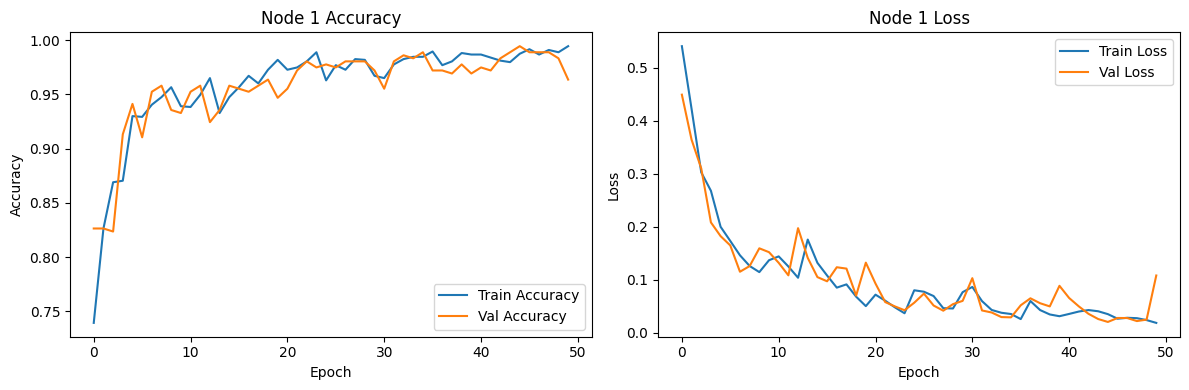

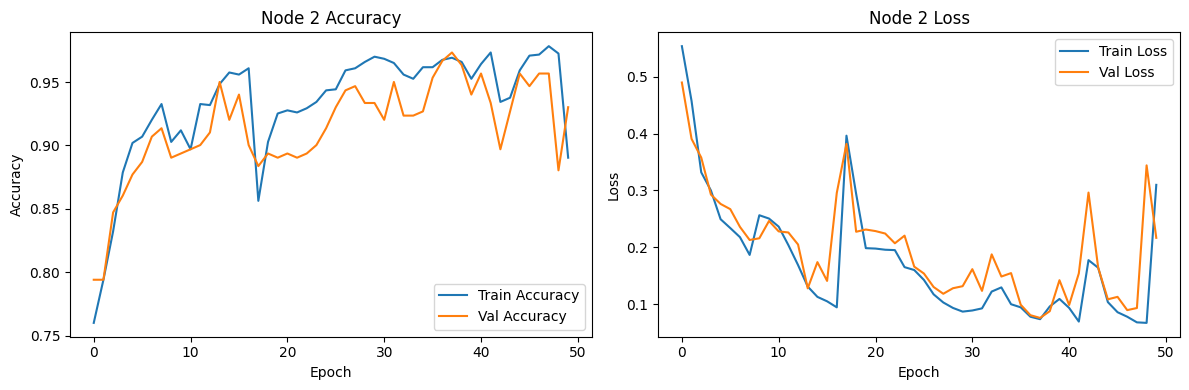

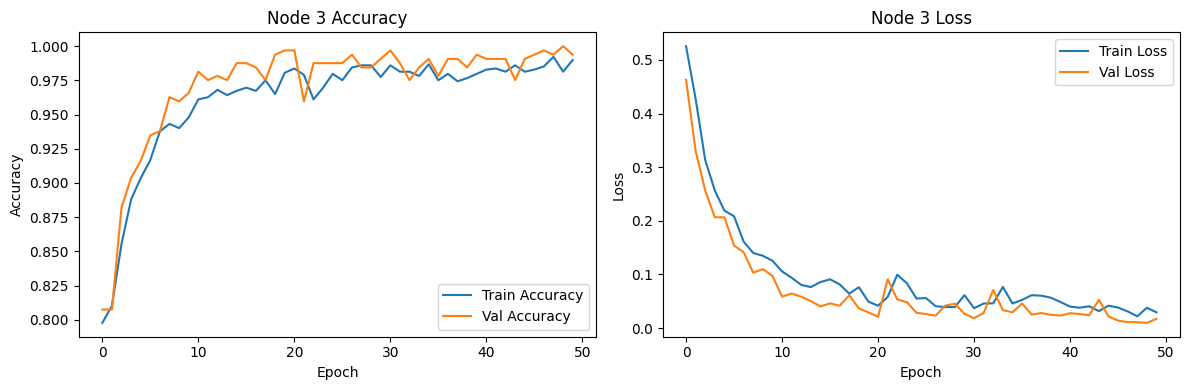

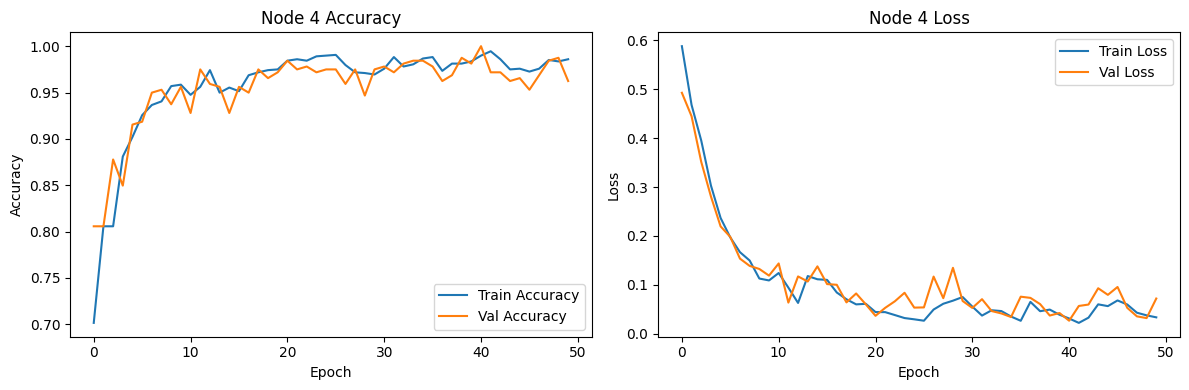

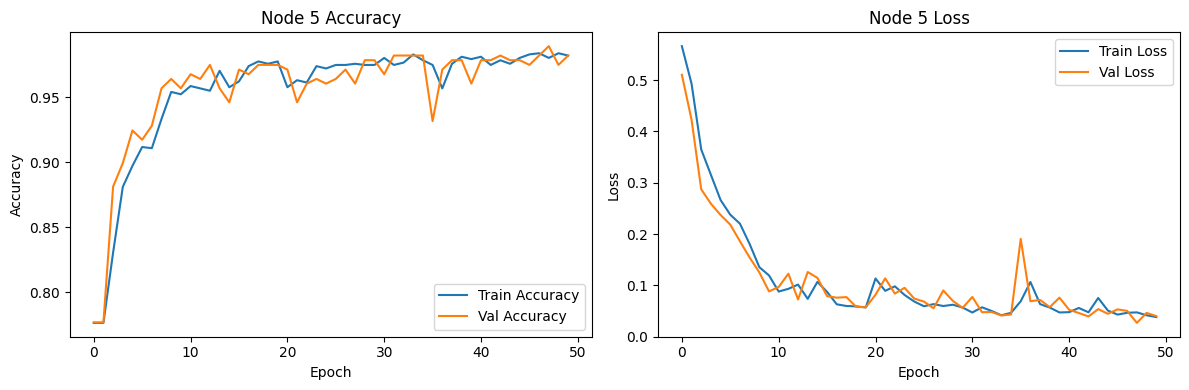

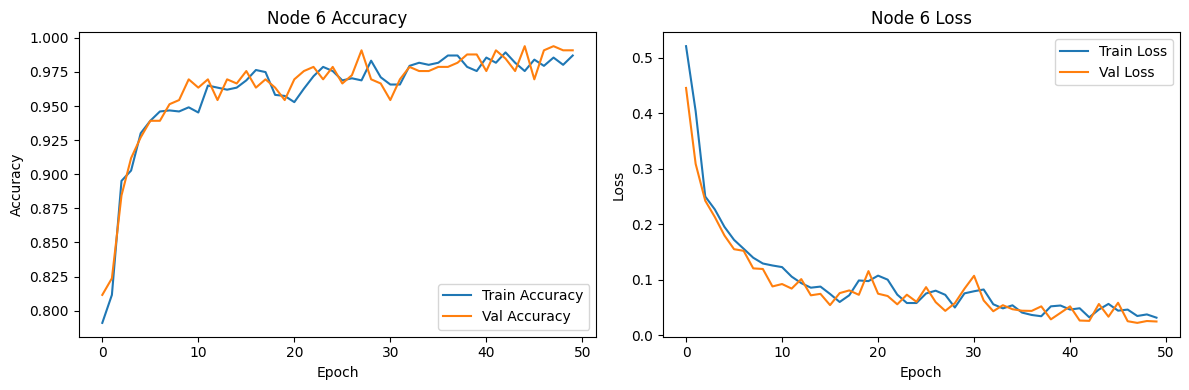

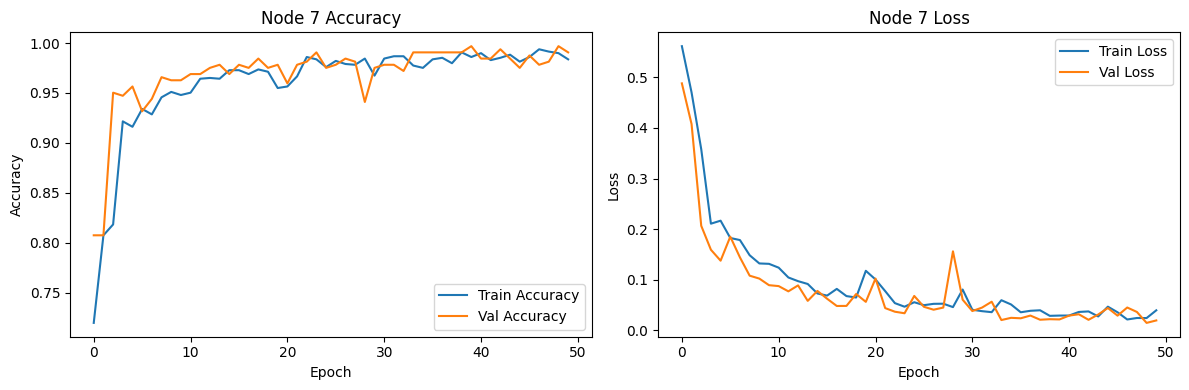

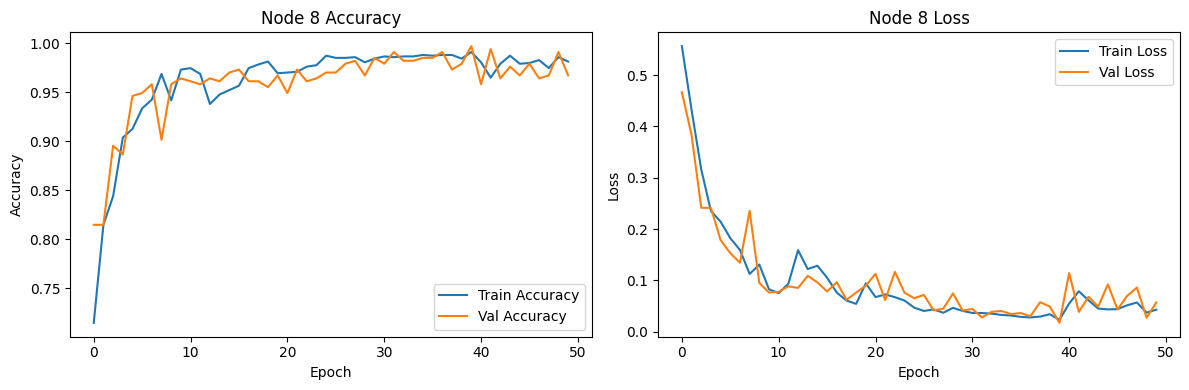

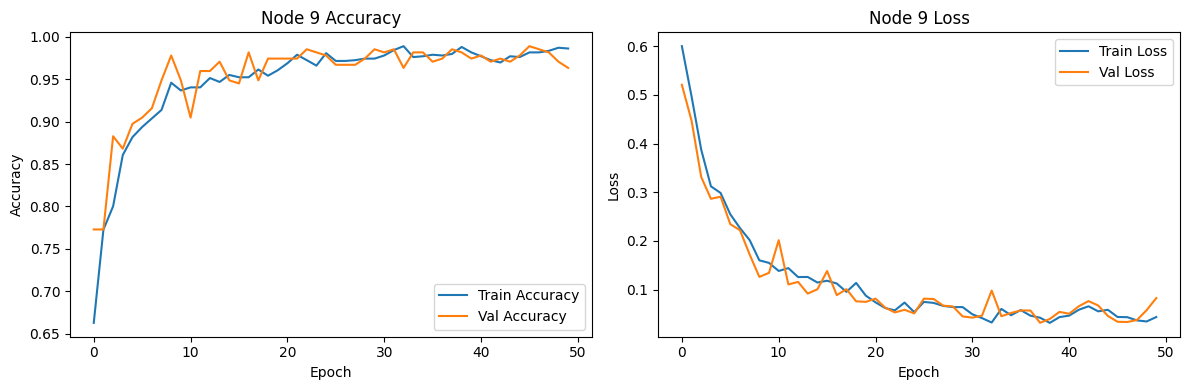

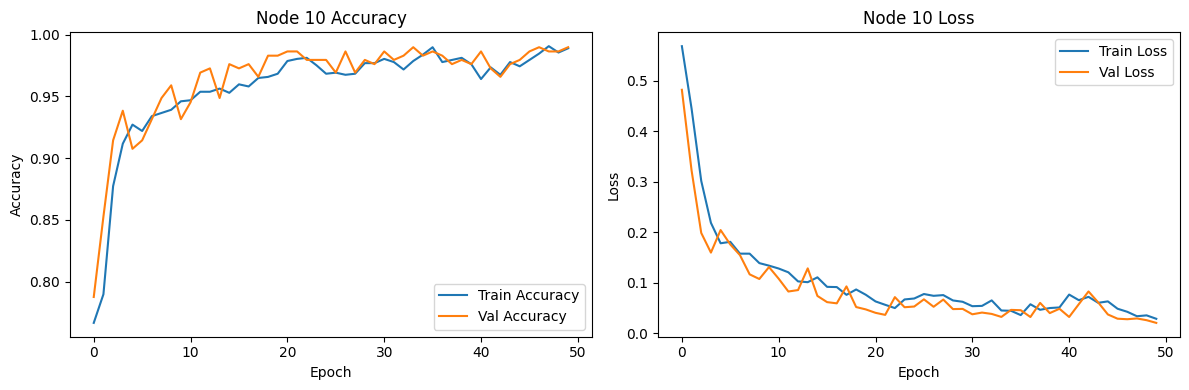

In [13]:
## import matplotlib.pyplot as plt

for nid, history in node_histories.items():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # —— Accuracy Plot —— #
    ax1.plot(history['accuracy'], label='Train Accuracy')
    ax1.plot(history['val_accuracy'], label='Val Accuracy')
    ax1.set_title(f'Node {nid} Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    # —— Loss Plot —— #
    ax2.plot(history['loss'], label='Train Loss')
    ax2.plot(history['val_loss'], label='Val Loss')
    ax2.set_title(f'Node {nid} Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()


Test set: 93 sequences generated.
Model file not found. Using Node 1's model from gossip_models.
2/2 - 0s - 13ms/step - accuracy: 0.9462 - loss: 0.1705
Total time taken for inferencing: 0.07 secs
Test Accuracy: 0.9462
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

Confusion Matrix
- x-axis: true labels
- y-axis: predicted labels
[[64  4]
 [ 1 24]]

Test Precision: 0.8571
Test Recall: 0.9600
Test F1-score: 0.9057


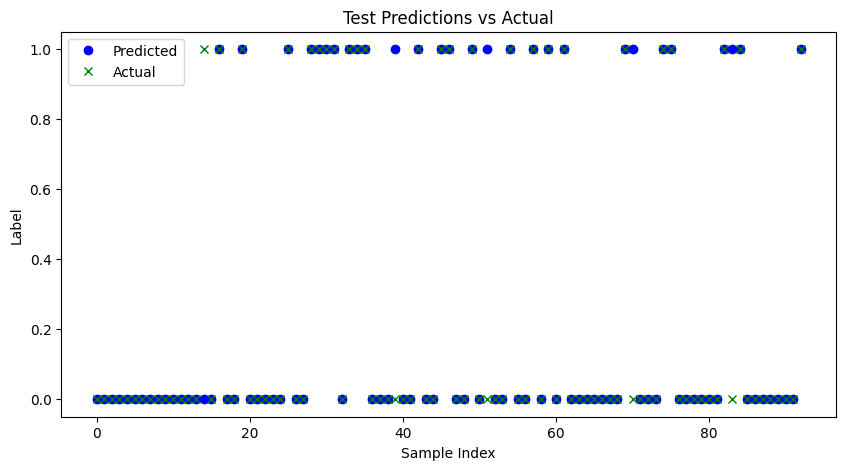

In [55]:
##############################################
# Model Evaluation on Test Set
##############################################

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from tensorflow.keras.models import load_model
import time

# Öncelikle model_path değişkenini tanımlayalım:
model_path = '/kaggle/working/binary_model_node_1.keras'

# 1. Generate Test Sequences:
last_test_seq = [
    test_df[test_df['id'] == engine_id][sequence_cols_25].values[-sequence_length:]
    for engine_id in test_df['id'].unique() if len(test_df[test_df['id'] == engine_id]) >= sequence_length
]
last_test_seq = np.asarray(last_test_seq).astype(np.float32)
print(f"Test set: {last_test_seq.shape[0]} sequences generated.")

# 2. Generate Test Labels:
y_mask = [len(test_df[test_df['id'] == engine_id]) >= sequence_length for engine_id in test_df['id'].unique()]
last_test_label = test_df.groupby('id')['failure_within_w1'].nth(-1)[y_mask].values
last_test_label = last_test_label.reshape(last_test_label.shape[0], 1).astype(np.float32)

# 3. Load the Best Model:
if os.path.isfile(model_path):
    print("Loading model from:", model_path)
    estimator = load_model(model_path)
else:
    print("Model file not found. Using Node 1's model from gossip_models.")
    estimator = gossip_models[1]

# 4. Evaluate Model on Test Set:
start = time.time()
scores_test = estimator.evaluate(last_test_seq, last_test_label, verbose=2, batch_size=50)
end = time.time()
print("Total time taken for inferencing: {:.2f} secs".format(end - start))
print("Test Accuracy: {:.4f}".format(scores_test[1]))

# 5. Predictions and Confusion Matrix:
y_pred_test = (estimator.predict(last_test_seq, verbose=1, batch_size=200) > 0.5).astype("int32")
y_true_test = last_test_label

# Save predictions to CSV:
pd.DataFrame(y_pred_test, columns=["Prediction"]).to_csv('binary_submit_test.csv', index=False)

print("\nConfusion Matrix")
print("- x-axis: true labels")
print("- y-axis: predicted labels")
cm_test = confusion_matrix(y_true_test, y_pred_test)
print(cm_test)

# 6. Compute Precision, Recall, and F1-score:
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test + 1e-8)
print("\nTest Precision: {:.4f}".format(precision_test))
print("Test Recall: {:.4f}".format(recall_test))
print("Test F1-score: {:.4f}".format(f1_test))

# 7. Plot Predictions vs Actual:
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test, color="blue", marker='o', linestyle='', label="Predicted")
plt.plot(y_true_test, color="green", marker='x', linestyle='', label="Actual")
plt.title("Test Predictions vs Actual")
plt.ylabel("Label")
plt.xlabel("Sample Index")
plt.legend(loc="upper left")
plt.show()


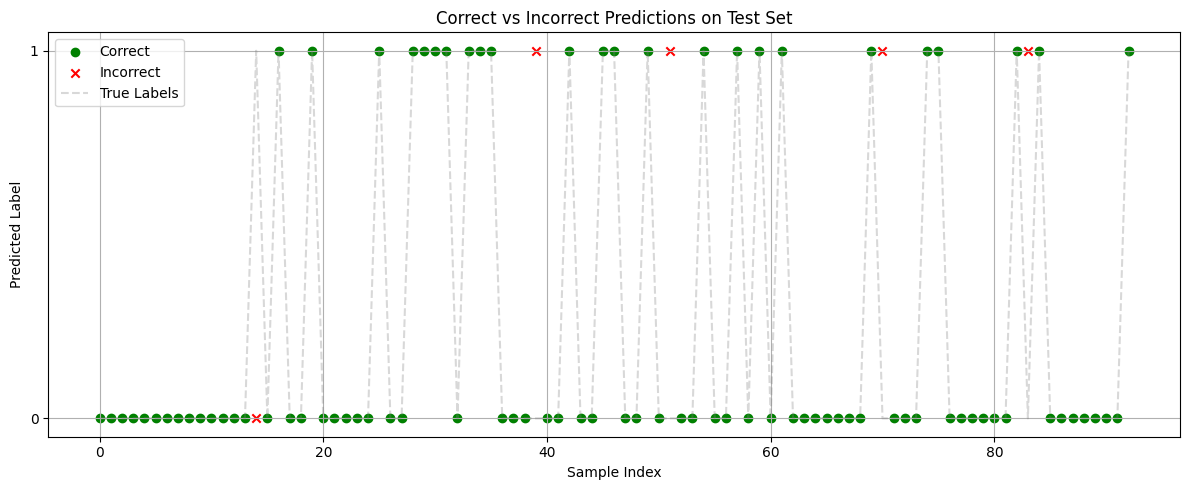

In [56]:
import matplotlib.pyplot as plt

# Doğru ve yanlış tahminlerin indekslerini al
correct_idx = np.where(y_pred_test == y_true_test)[0]
incorrect_idx = np.where(y_pred_test != y_true_test)[0]

# Yeni grafik
plt.figure(figsize=(12, 5))
plt.scatter(correct_idx, y_pred_test[correct_idx], color='green', label='Correct', marker='o')
plt.scatter(incorrect_idx, y_pred_test[incorrect_idx], color='red', label='Incorrect', marker='x')
plt.plot(y_true_test, color='gray', alpha=0.3, linestyle='--', label='True Labels')

plt.title("Correct vs Incorrect Predictions on Test Set")
plt.xlabel("Sample Index")
plt.ylabel("Predicted Label")
plt.yticks([0, 1])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


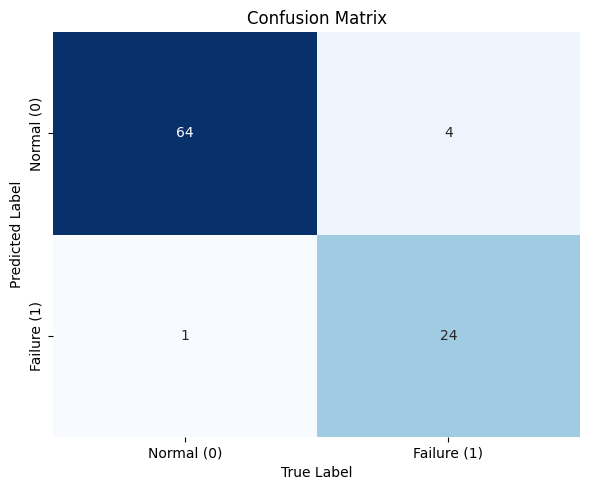

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true_test, y_pred_test)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Normal (0)", "Failure (1)"],
            yticklabels=["Normal (0)", "Failure (1)"])
plt.xlabel("True Label")
plt.ylabel("Predicted Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


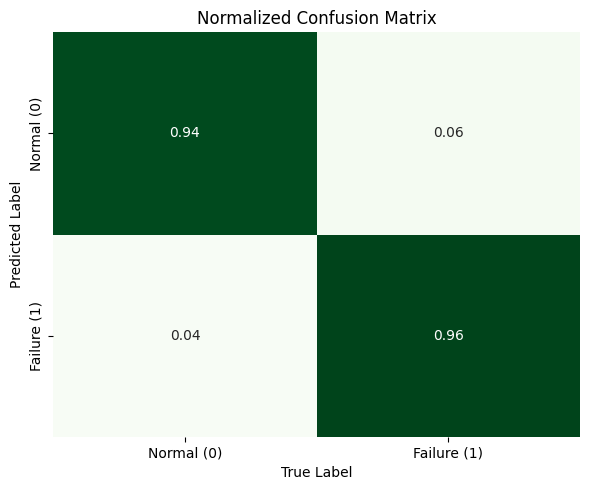

In [58]:
cm_norm = confusion_matrix(y_true_test, y_pred_test, normalize='true')

plt.figure(figsize=(6, 5))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Greens', cbar=False,
            xticklabels=["Normal (0)", "Failure (1)"],
            yticklabels=["Normal (0)", "Failure (1)"])
plt.xlabel("True Label")
plt.ylabel("Predicted Label")
plt.title("Normalized Confusion Matrix")
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


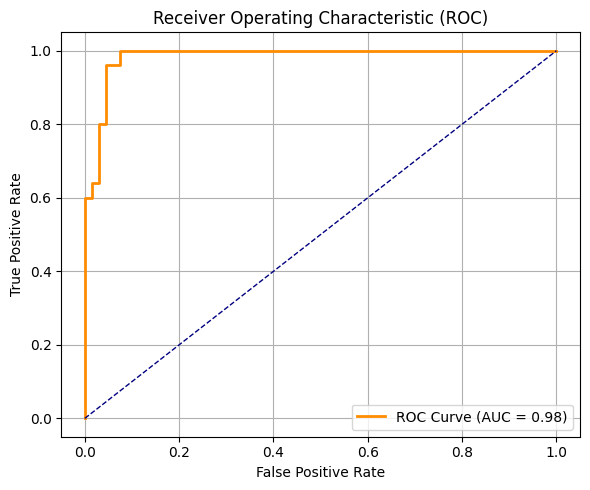

In [59]:
# Bu y_probs_test olacak:
y_probs_test = estimator.predict(last_test_seq, verbose=1, batch_size=200)

# Sonra ROC için kullanabilirsin:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_true_test, y_probs_test)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


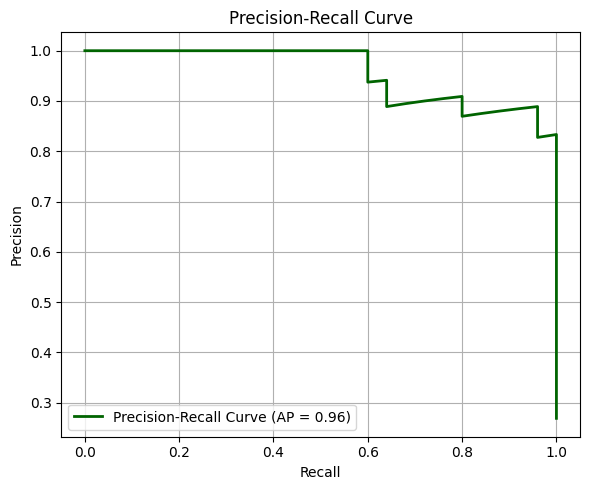

In [60]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# precision-recall eğrisi için gerekli değerleri hesapla
precision, recall, thresholds = precision_recall_curve(y_true_test, y_probs_test)
avg_precision = average_precision_score(y_true_test, y_probs_test)

# çizim
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, color='darkgreen', lw=2,
         label=f'Precision-Recall Curve (AP = {avg_precision:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()



<Axes: >

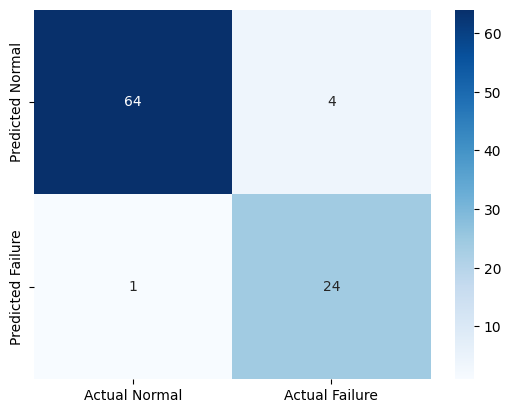

In [61]:
import numpy as np

cm = confusion_matrix(y_true_test, y_pred_test)
cm_norm = confusion_matrix(y_true_test, y_pred_test, normalize='true')

labels = np.asarray([["{0}\n({1:.0%})".format(n, p) for n, p in zip(row, row_norm)]
                     for row, row_norm in zip(cm, cm_norm)])


sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Actual Normal", "Actual Failure"],
            yticklabels=["Predicted Normal", "Predicted Failure"])


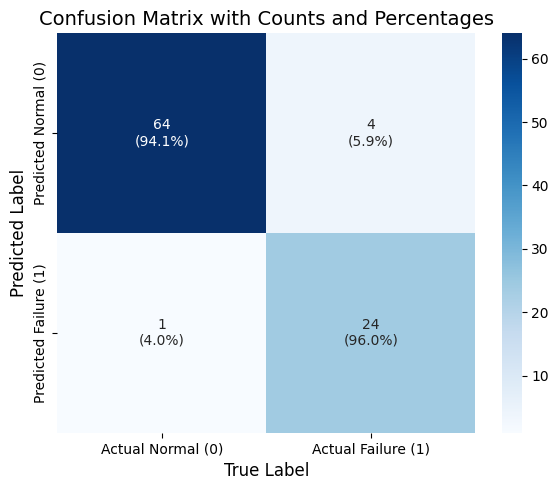

In [62]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Varsayılan confusion matrix hesaplaması
cm = confusion_matrix(y_true_test, y_pred_test)
cm_norm = confusion_matrix(y_true_test, y_pred_test, normalize='true')

# Her hücreye sayı + oran (yüzde) ekle
labels = np.array([["{0}\n({1:.1%})".format(cm[i, j], cm_norm[i, j]) 
                    for j in range(cm.shape[1])] for i in range(cm.shape[0])])

# Görselleştirme
plt.figure(figsize=(6, 5))

sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=True,
            xticklabels=["Actual Normal (0)", "Actual Failure (1)"],
            yticklabels=["Predicted Normal (0)", "Predicted Failure (1)"])

plt.xlabel("True Label", fontsize=12)
plt.ylabel("Predicted Label", fontsize=12)
plt.title("Confusion Matrix with Counts and Percentages", fontsize=14)
plt.tight_layout()
plt.show()


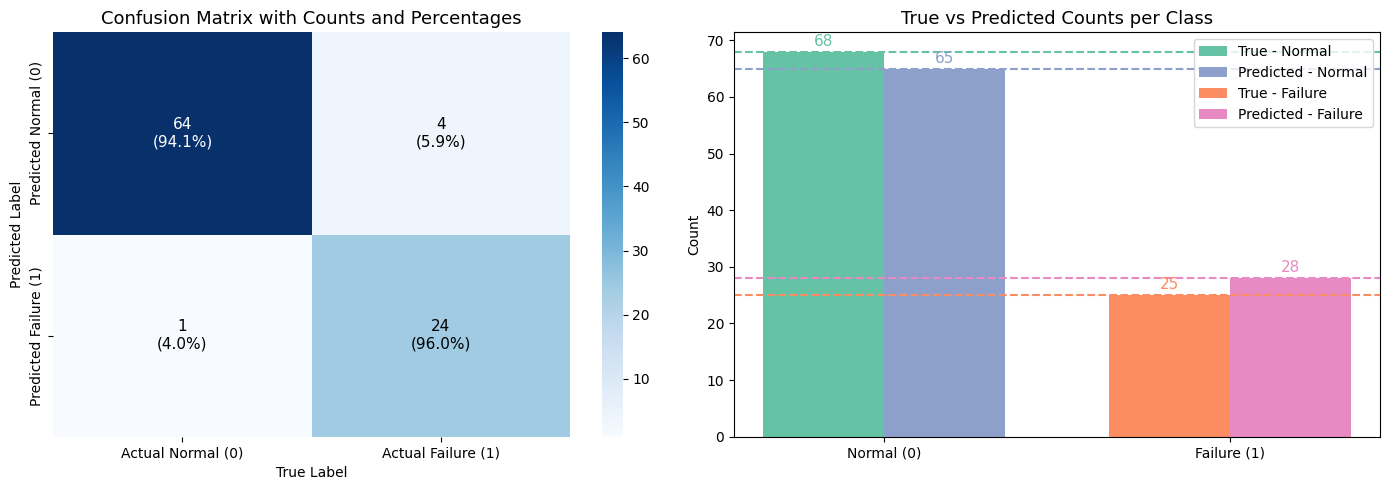

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from collections import Counter
from matplotlib.patches import Patch


# Flatten arrays
y_true_flat = np.array(y_true_test).flatten()
y_pred_flat = np.array(y_pred_test).flatten()

true_counts = Counter(y_true_flat)
pred_counts = Counter(y_pred_flat)

# Sınıf etiketleri ve değerler
classes = ["Normal (0)", "Failure (1)"]
true_vals = [true_counts[0], true_counts[1]]
pred_vals = [pred_counts[0], pred_counts[1]]
x = np.arange(len(classes))  # [0, 1]
bar_width = 0.35

# Renk paletleri
true_colors = ['#66c2a5', '#fc8d62']     # Normal, Failure - True
pred_colors = ['#8da0cb', '#e78ac3']     # Normal, Failure - Predicted

# ------------------------
# Confusion Matrix Plot
# ------------------------
fig = plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)

cm = confusion_matrix(y_true_flat, y_pred_flat)
cm_percent = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

ax = sns.heatmap(cm, annot=False, fmt="d", cmap="Blues",
                 xticklabels=["Actual Normal (0)", "Actual Failure (1)"],
                 yticklabels=["Predicted Normal (0)", "Predicted Failure (1)"],
                 cbar=True)

for i in range(2):
    for j in range(2):
        value = cm[i, j]
        percent = cm_percent[i, j] * 100
        # Siyah zemin için beyaz yazı, açık zemin için siyah yazı
        text_color = 'white' if cm[i, j] > np.max(cm)*0.6 else 'black'
        ax.text(j + 0.5, i + 0.5,
                f"{value}\n({percent:.1f}%)",
                ha="center", va="center", color=text_color, fontsize=11)

plt.title("Confusion Matrix with Counts and Percentages", fontsize=13)
plt.xlabel("True Label")
plt.ylabel("Predicted Label")

# ------------------------
# Bar Plot: True vs Predicted
# ------------------------
plt.subplot(1, 2, 2)

bars1 = plt.bar(x - bar_width/2, true_vals, bar_width,
                label="True", color=true_colors)

bars2 = plt.bar(x + bar_width/2, pred_vals, bar_width,
                label="Predicted", color=pred_colors)

# Çizgiler ve değer yazıları
for i in range(len(classes)):
    # True çizgi
    plt.axhline(true_vals[i], color=true_colors[i], linestyle="--", linewidth=1.5)
    plt.text(i - bar_width/2, true_vals[i] + 1, f"{true_vals[i]}",
             ha="center", color=true_colors[i], fontsize=11)

    # Predicted çizgi
    plt.axhline(pred_vals[i], color=pred_colors[i], linestyle="--", linewidth=1.5)
    plt.text(i + bar_width/2, pred_vals[i] + 1, f"{pred_vals[i]}",
             ha="center", color=pred_colors[i], fontsize=11)

plt.xticks(x, classes)
plt.ylabel("Count")
plt.title("True vs Predicted Counts per Class", fontsize=13)

# Legend
legend_elements = [
    Patch(facecolor=true_colors[0], label='True - Normal'),
    Patch(facecolor=pred_colors[0], label='Predicted - Normal'),
    Patch(facecolor=true_colors[1], label='True - Failure'),
    Patch(facecolor=pred_colors[1], label='Predicted - Failure'),
]
plt.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()
